# Assignment 3

## Exercise
Documentation and code of CLIP: https://github.com/openai/CLIP

In this notebook, you will be working with CLIP (Contrastive Language-Image Pre-Training) model. We will be using the implementation and the pre-trained model based on ViT. This is a visual transformer, see the paper for details, or the (upcoming) course slides on ILIAS.

In [1]:
import os
import sys

import numpy as np
import torch
print("Torch version:", torch.__version__)

try:
    import pandas
except ModuleNotFoundError:
    !conda install pandas

Torch version: 2.0.1


In [ ]:
#conda update -n base -c defaults conda
#conda install torchvision -c pytorch

In [2]:
WORKWITHCOLAB = False

# Setup: Preparation for Colab
***If you work on your own local environment, you can skip this part and go directly to the Warm-Up.***

Make sure you're running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will install the `clip` package and its dependencies, and check if PyTorch 1.7.1 or later is installed.

In [3]:
if WORKWITHCOLAB:
    !pip install cython

In [4]:
if WORKWITHCOLAB:
    try:
        from google.colab import drive
    except ModuleNotFoundError:
        !pip install google-colab

In [5]:
# Mount your Google Drive to the Colab VM:
if WORKWITHCOLAB:
    from google.colab import drive
    drive.mount('/content/drive')

    # TODO: Save the unzipped assignment folder in a filder on your google Drive. 
    # TODO: Enter the foldername in your Drive where you have saved it, e.g. 'assignment4/'
    FOLDERNAME = None
    FOLDERNAME = "MultimodalSemantics_SS2023"
    assert FOLDERNAME is not None, "enter the foldername."

    # Now that we've mounted your Drive, this ensures that
    # the Python interpreter of the Colab VM can load
    # python files from within it.
    sys.path.append('/content/drive/MyDrive/{}'.format(FOLDERNAME))

In [6]:
if WORKWITHCOLAB:
    %load_ext Cython

In [7]:
if WORKWITHCOLAB:
    !cd /content/drive/MyDrive/$FOLDERNAME/
    !ls .

# Setting up working with CLIP

This is a self-contained notebook that shows how to download and run CLIP models, calculate the similarity between arbitrary image and text inputs, and perform zero-shot image classifications.

In [8]:
# Install CLIP if you don't have it yet
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-_kmlo3e0
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-_kmlo3e0
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done


In [9]:
from pkg_resources import packaging

In [10]:
import torchvision
print("Torch vision version: ", torchvision.__version__)
#import torch
#torch.__version__

Torch vision version:  0.15.2


In [ ]:
# If necessary:
#!conda update --yes pytorch torchvision

In [ ]:
# Getting a warn(f"Failed to load image Python extension: {e}") error?
# Fix:
#!pip3 uninstall --yes torchvision
#!pip3 install torchvision==0.12.0

In [11]:
# We need additional packages for loading (and visualising) the images
import IPython.display
import matplotlib.pyplot as plt
from collections import OrderedDict

try:
    import skimage
except ModuleNotFoundError:
    !conda install --yes scikit-image 
    import skimage
from PIL import Image

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Loading the model and the image preprocessor

`clip.available_models()` will list the names of available CLIP models.

In [12]:
import clip
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

We load the pre-trained ViT-B/32 `model` and the image preprocessor (`process`)

In [13]:
model, preprocess = clip.load("ViT-L/14")
if torch.cuda.is_available():
    model.cuda().eval()
else:
    model.eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 427,616,513
Input resolution: 224
Context length: 77
Vocab size: 49408


## Exercise: Language Perception of Colour II
In the exercises, you will use the coda dataset as in the previous assignment: https://github.com/nala-cub/coda

This exercise now evaluates VL-models on the colour prediction task. 
So, again, follow the instructions below. 

### Instructions
* Load the coda dataset. We will only use the *object names* and *colours* for this exercise.
* Take the same 20 object names from different categories (e.g., vegetable/fruits, vehicles, etc.) that you used in Assignment 2.
* Use the reference data of colour attributions that you created in Assigment 2.
* The task now is to use CLIP for predicting the top colours that for each of your objects, as explained below. 
 
#### Approach
We will compare different methods that diverge in the information that the modalities capture, and will perform zero-shot classification to predict typical colours of objects using CLIP. <br/>
Regarding the prompts mentioned below, see also the file `templates.yaml` of the coda dataset.

##### Data Preparation
You need to set up your coda data and the data structures to extract the information needed for the methods. See the setup of the `swig_data` conducted above for zero-shot classification. 

1. **CLIP-col**: 
   *  Visual embeddings of images of colours   <br/>
      Retrieve images from the web of all target colours under study, and store them in `coloured_objects`. Do not forget to give the source of the images in your report.
    * For the textual representations, adapt the prompts you used in the previous assignment, but use the phrases "this colour/these colours" instead of masking the colour words. 
      * For example, you could use the template 
     `"Most {object_areis_pl} have this colour."` <br/>
     
2. **CLIP-Tcol**: Baseline to **CLIP-col** without using images:
   * "Visual embeddings" are actually textual embeddings of the colour *words*   <br/>
      That is, use the textual encoder to extract the "visual embeddings" of each colour term.  
    * For the textual representations, follow CLIP-col.<br/>

3. **CLIP-obj**: 
   Here, you first have to define your target classes. These will be the target colours. 
   * Visual embeddings of images of the target objects <br/>
      These images are grey-scale drawings. You can retrieve corresponding images from the MultPIC database, or query others (report the source of the photos). 
   * For the textual representations use simple prompts, such as <br/>
       `"This object usually is {}."`, <br/>
       `"This object usually is {} coloured."`

### Tasks 1: Analysis of the VL-Models
1. Briefly give an overview (in a table) of the methods in terms of with which modality they encode the *target object* and the *target colour(s)*, respectively. 
  | Method    | Image | Language |
  | ------    | ----- | -------- |
  | CLIP-col  |   ?   |    ?     |
  | CLIP-Tcol |   ?   |    ?     |
  | CLIP-obj  |   ?   |    ?     |
2. Compute the accuracy of each model on the colour prediction task using your small reference data (previous coda assignment).
3. Compare the effectiveness of the models, and discuss the possible reasons for the differences. 
4. For each model, are there objects for which it predicts wrong colours? Why could this be the case?
5. Summarise in a few sentences your conclusions regarding the colour knowledge one can learn from visual-linguistic representations (i.e., from the visual modality and from text use). Also take into account the different models. 

### Tasks 2: Comparison of Language Model  against VL-Model
*See the pdf of the assignment.*

### Task 3: Pen & Paper Questions
*See the pdf of the assignment.*

***Submit the following files through ILIAS***:
* `03ex_vlmodels_clip.ipynb`: your completed jupyter notebook
* `03ex_vlmodels_clip.[txt|md]`: a plain text file that contains your answers to the task and questions.


### Setting up coloured_objects<a name="setup_coloured_objects" />
#### EXAMPLE:

In [107]:
# TODO: set up your paths.
# FOLDERNAME = "data"
# image_dir = '{}/coloured_objects/'.format(FOLDERNAME)
# data_dir = '{}/coloured_objects/'.format(FOLDERNAME)

# for filename in [filename for filename in os.listdir(data_dir)]:
#     print(filename)

In [ ]:
# # images in coda to use and some descriptions for them written by yourselves
# descriptions = [
#     ("PICTURE_69.png", "A grey-scale photo of a banana ."),
#     ("PICTURE_42.png", "A photo of a pear ."),
# ]

In [ ]:
# colour_classes = ['yellow', 'blue', 'brown', 'pink', 'gray', 'black', 'red', 'green', 'orange', 'purple', 'white']
# colour_class2idx = {c:idx for (idx,c) in enumerate(colour_classes)}

In [ ]:
# coloured_objects_data = {
#     # Q: How to adapt to multi-label prediction?
#     "PICTURE_69.png": "yellow",
#     "PICTURE_42.png": "green",
# }

In [ ]:
# # For zero-shot classification
# # We want to use more than one prompt, and get a 
# # mean prompt embedding for them: 
# colour_templates = ["A photo of an object that is usually {} coloured .", 
#                    "The color of this object on the photo usually is {} ."]
# print(f"{len(colour_classes)} classes, {len(colour_templates)} templates")

### Load Coda

In [20]:
## YOUR CODE COMES HERE

# load coda
try:
    from datasets import load_dataset
except:
    !pip install datasets
    from datasets import load_dataset

coda_dataset = load_dataset("corypaik/coda")
coda_dataset = coda_dataset["train"]

Found cached dataset coda (/home/kafka/.cache/huggingface/datasets/corypaik___coda/default/1.0.1/cebd02670e856cb431040f8050cc5e0dcf887096aa9a62857be5596abfe23656)


  0%|          | 0/3 [00:00<?, ?it/s]

In [23]:
coda_dataset.features

{'class_id': Value(dtype='string', id=None),
 'display_name': Value(dtype='string', id=None),
 'ngram': Value(dtype='string', id=None),
 'label': Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None),
 'object_group': ClassLabel(names=['Single', 'Multi', 'Any'], id=None),
 'text': Value(dtype='string', id=None),
 'template_group': ClassLabel(names=['clip-imagenet', 'text-masked'], id=None),
 'template_idx': Value(dtype='int32', id=None)}

In [39]:
# randomly select 20
# selected_indexes = np.random.choice(len(object_names), 20)
# selected_objects = [object_names[idx] for idx in selected_indexes]
# print(selected_objects)

selected_objects = ['Ambulance', 'Crow', 'Ketchup', 'Mobile phone', 'Porcupine', 
                    'Apple', 'Microphone', 'Skyscraper', 'Limousine',
                    'Canoe', 'Light bulb', 'Asparagus', 'Violin', 'Sea turtle', 
                    'Skull', 'Giraffe', 'Traffic Light', 'Drawer', 
                    'Jeans', 'Flashlight']

assert len(selected_objects) == 20

In [40]:
reference_colours = ["white", "black", "red", "black", "brown", "red", "black", 
                    "gray", "white", "white", "yellow", "green", "black", 
                    "green", "white", "yellow", "red", "white", "blue", "white"]

assert len(selected_objects) == len(reference_colours)

In [41]:
set(reference_colours)

{'black', 'blue', 'brown', 'gray', 'green', 'red', 'white', 'yellow'}

### Create Color Images

In [55]:
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = "retina"

# string to RGB tuple
# source: https://www.webucator.com/article/python-color-constants-module/
colour_rgb_dict = {
    "black": (0, 0, 0),
    "blue": (0, 0, 255),
    "brown": (165, 42, 42),
    "gray": (128, 128, 128),
    "green": (0, 255, 0),
    "red": (255, 0, 0),
    "white": (255,255,255),
    "yellow": (255, 255, 0)
}

colour_image_dims = (300, 300)

# https://stackoverflow.com/a/38900699
def generate_colour_image(colour_name: str, size=(300, 300), colour_dict=colour_rgb_dict) -> Image.Image:
    assert colour_name in colour_dict.keys()
    
    img = Image.new("RGB", size=size, color=colour_dict[colour_name])
    return img

# test
yellow_img = generate_colour_image("yellow")
yellow_img.size

(300, 300)

In [81]:
reference_colour_images = [generate_colour_image(c) for c in reference_colours]
preprocessed_ref_images = [preprocess(img) for img in reference_colour_images]

### Build inputs for CLIP

In [82]:
def build_inputs(colour_texts, images):
    if torch.cuda.is_available():
        image_input = torch.tensor(np.stack(images)).cuda()
        text_tokens = clip.tokenize([ref_colour for ref_colour in colour_texts]).cuda()
        
    else:
        image_input = torch.tensor(np.stack(images))
        text_tokens = clip.tokenize([ref_colour for ref_colour in colour_texts])
        
    return image_input, text_tokens

image_input, text_tokens = build_inputs(reference_colours, preprocessed_ref_images)


### CLIP-col : Colour Image to Colour Name similarity

In [166]:
def get_features(image_input, text_tokens, model=model, norm=True):
    with torch.no_grad():
        image_features = model.encode_image(image_input).float()
        text_features = model.encode_text(text_tokens).float()
    
    if norm:
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        
    return image_features, text_features

colour_image_features, colour_name_features = get_features(image_input, text_tokens)

In [167]:
similarity = colour_name_features.cpu().numpy() @ colour_image_features.cpu().numpy().T
similarity.shape

(20, 20)

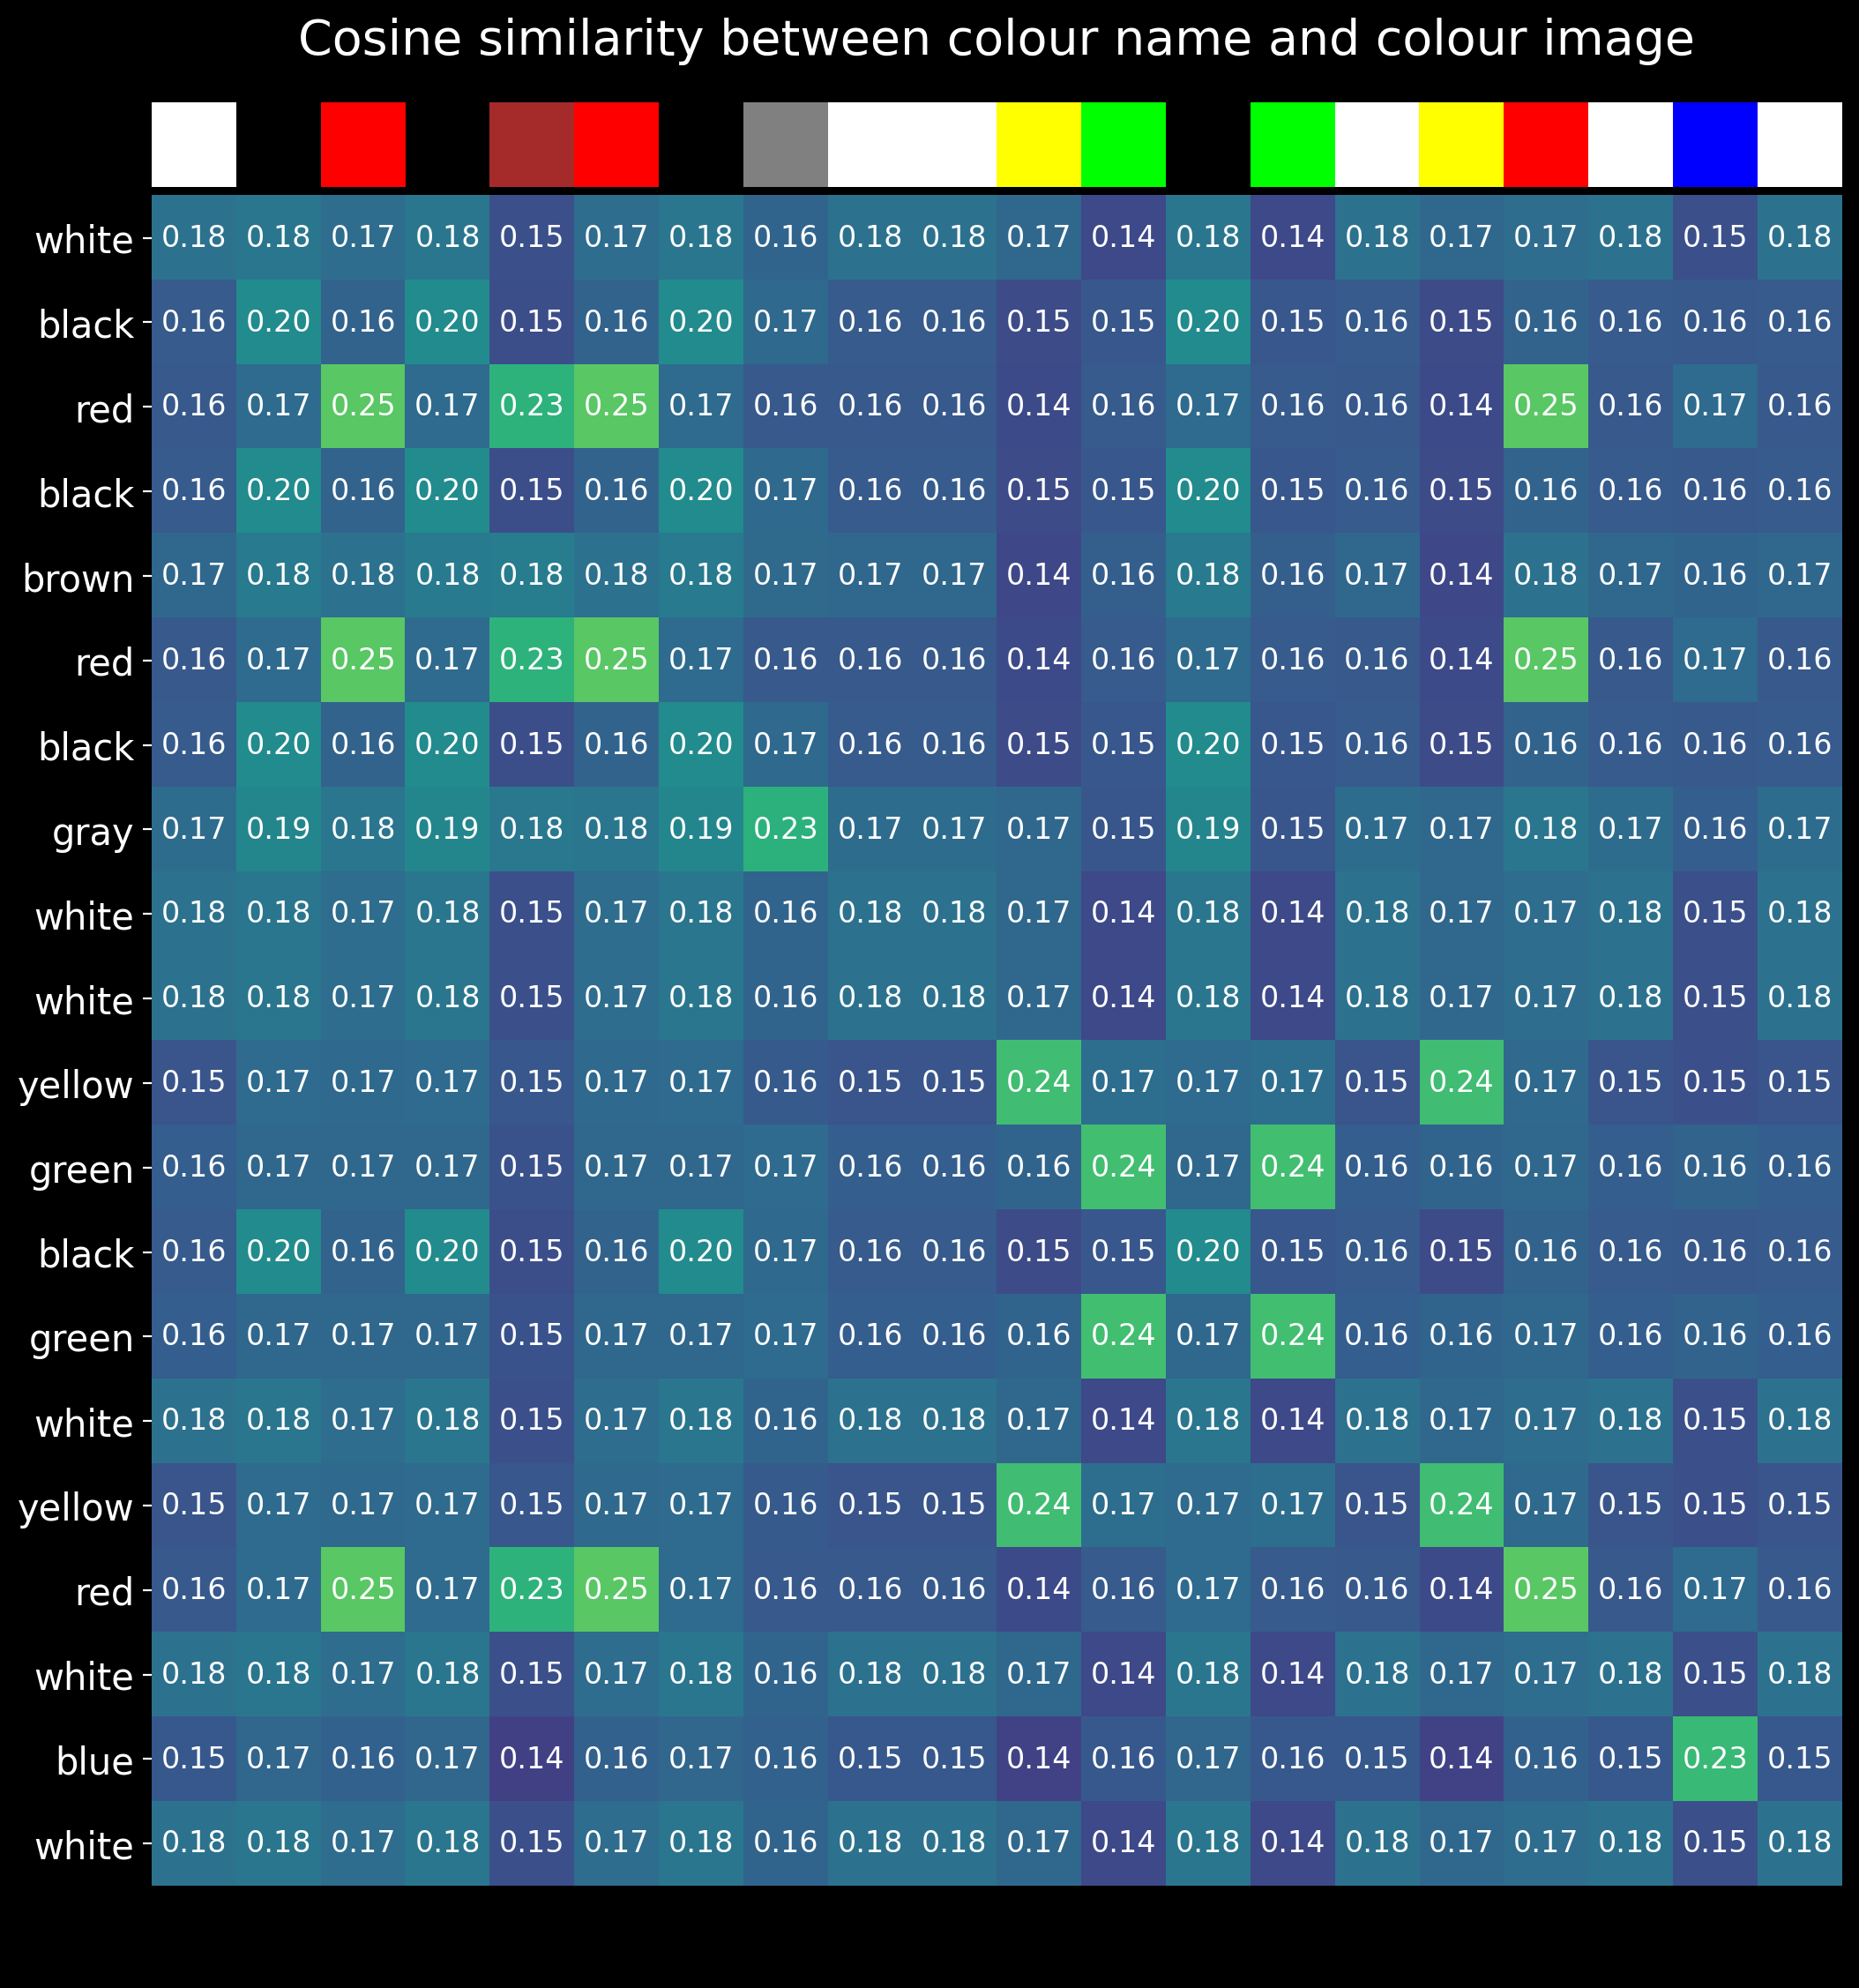

In [168]:
def plot_conf_matrix(text_list, image_list, similarity, title):
    count = len(text_list)
    plt.figure(figsize=(20, 14))
    plt.imshow(similarity, vmin=0.1, vmax=0.3)
    plt.yticks(range(count), text_list, fontsize=15)
    plt.xticks([])

    for i, image in enumerate(image_list):
        plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
    
    for x in range(similarity.shape[1]):
        for y in range(similarity.shape[0]):
            plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)
        
    for side in ["left", "top", "right", "bottom"]:
        plt.gca().spines[side].set_visible(False)

    plt.xlim([-0.5, count - 0.5])
    plt.ylim([count + 0.5, -2])

    plt.title(title, size=20)
    
    
plot_conf_matrix(reference_colours, reference_colour_images, similarity,
                 "Cosine similarity between colour name and colour image")

### CLIP-col : Template with Colour name and object colour similarity

In [106]:
templates = list()
for obj_name, colour in zip(selected_objects, reference_colours):
    template_string = f"{obj_name} is of colour {colour} ."
    templates.append(template_string) 
    
templates    

['Ambulance is of colour white .',
 'Crow is of colour black .',
 'Ketchup is of colour red .',
 'Mobile phone is of colour black .',
 'Porcupine is of colour brown .',
 'Apple is of colour red .',
 'Microphone is of colour black .',
 'Skyscraper is of colour gray .',
 'Limousine is of colour white .',
 'Canoe is of colour white .',
 'Light bulb is of colour yellow .',
 'Asparagus is of colour green .',
 'Violin is of colour black .',
 'Sea turtle is of colour green .',
 'Skull is of colour white .',
 'Giraffe is of colour yellow .',
 'Traffic Light is of colour red .',
 'Drawer is of colour white .',
 'Jeans is of colour blue .',
 'Flashlight is of colour white .']

In [140]:
image_urls = {
    "Ambulance": "https://upload.wikimedia.org/wikipedia/commons/thumb/3/30/Fiat_Ducato_Ambulance_Belgrade_city.jpg/800px-Fiat_Ducato_Ambulance_Belgrade_city.jpg",
    "Crow": "https://upload.wikimedia.org/wikipedia/commons/a/a9/Corvus_corone_-near_Canford_Cliffs%2C_Poole%2C_England-8.jpg",
    "Ketchup": "https://upload.wikimedia.org/wikipedia/commons/thumb/a/aa/Cup_of_Ketchup_%2827415520141%29.jpg/800px-Cup_of_Ketchup_%2827415520141%29.jpg",
    "Mobile phone": "https://upload.wikimedia.org/wikipedia/commons/7/79/Galaxy_S23.png",
    "Porcupine": "https://upload.wikimedia.org/wikipedia/commons/thumb/c/c9/Wild_shortbeak_echidna.jpg/800px-Wild_shortbeak_echidna.jpg",
    "Apple": "https://upload.wikimedia.org/wikipedia/commons/2/25/Alice_%28apple%29.jpg",
    "Microphone": "https://upload.wikimedia.org/wikipedia/commons/f/f2/Western_Electric_double_button_carbon_microphone.jpg",
    "Skyscraper": "https://upload.wikimedia.org/wikipedia/commons/3/38/Home_Insurance_Building.JPG",
    "Limousine": "https://upload.wikimedia.org/wikipedia/commons/9/9b/98-02_Lincoln_Town_Car_limousine.jpg",
    "Canoe": "https://upload.wikimedia.org/wikipedia/commons/0/08/1998-10-tema-canoe.jpg",
    "Light Bulb": "https://upload.wikimedia.org/wikipedia/commons/thumb/f/f7/Tungsten_filament_in_an_incandescent_light.JPG/800px-Tungsten_filament_in_an_incandescent_light.JPG",
    "Asparagus": "https://upload.wikimedia.org/wikipedia/commons/thumb/f/ff/Asparagus_soup_%28spargelsuppe%29.jpg/800px-Asparagus_soup_%28spargelsuppe%29.jpg",
    "Violin": "https://upload.wikimedia.org/wikipedia/commons/4/44/Violin_MET_255844.jpg",
    "Sea turtle": "https://upload.wikimedia.org/wikipedia/commons/thumb/8/8c/Green_Turtle_Chelonia_Mydas_%28223128015%29.jpeg/800px-Green_Turtle_Chelonia_Mydas_%28223128015%29.jpeg",
    "Skull": "https://upload.wikimedia.org/wikipedia/commons/thumb/8/85/Aardwolf_Skull.JPG/666px-Aardwolf_Skull.JPG",
    "Giraffe": "https://upload.wikimedia.org/wikipedia/commons/thumb/e/e0/Giraffa_camelopardalis_angolensis.jpg/450px-Giraffa_camelopardalis_angolensis.jpg",
    "Traffic Light": "https://upload.wikimedia.org/wikipedia/commons/d/df/Traffic_Lights_in_Vienna.jpg",
    "Drawer": "https://upload.wikimedia.org/wikipedia/commons/thumb/7/7e/Drawer.agr.jpg/714px-Drawer.agr.jpg",
    "Jeans": "https://upload.wikimedia.org/wikipedia/commons/thumb/5/5a/Jeans.jpg/401px-Jeans.jpg",
    "Flashlight": "https://upload.wikimedia.org/wikipedia/commons/7/71/Flash_Light_Turned_On.png"
}




In [149]:
import requests
from typing import Dict

def load_images_from_urls(image_urls: Dict):
    images = list()
    obj_names = list()
    for obj_name, url in image_urls.items():
        try:
            img = Image.open(requests.get(url, stream=True).raw)
            
            images.append(img)
            obj_names.append(obj_name)
        except Exception as e:
            print(e)
            print(obj_name)
            print(url)
        
    return images, obj_names

object_images, obj_names = load_images_from_urls(image_urls)

In [169]:
# preprocess
prep_object_images = [preprocess(img) for img in object_images]

In [181]:
image_inputs, text_inputs = build_inputs(templates, prep_object_images)

In [182]:
image_features, text_features = get_features(image_inputs, text_inputs)

In [172]:
def get_similarity(text_features, image_features):
    similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T
    return similarity

In [183]:
color_similarity = get_similarity(text_features, image_features)

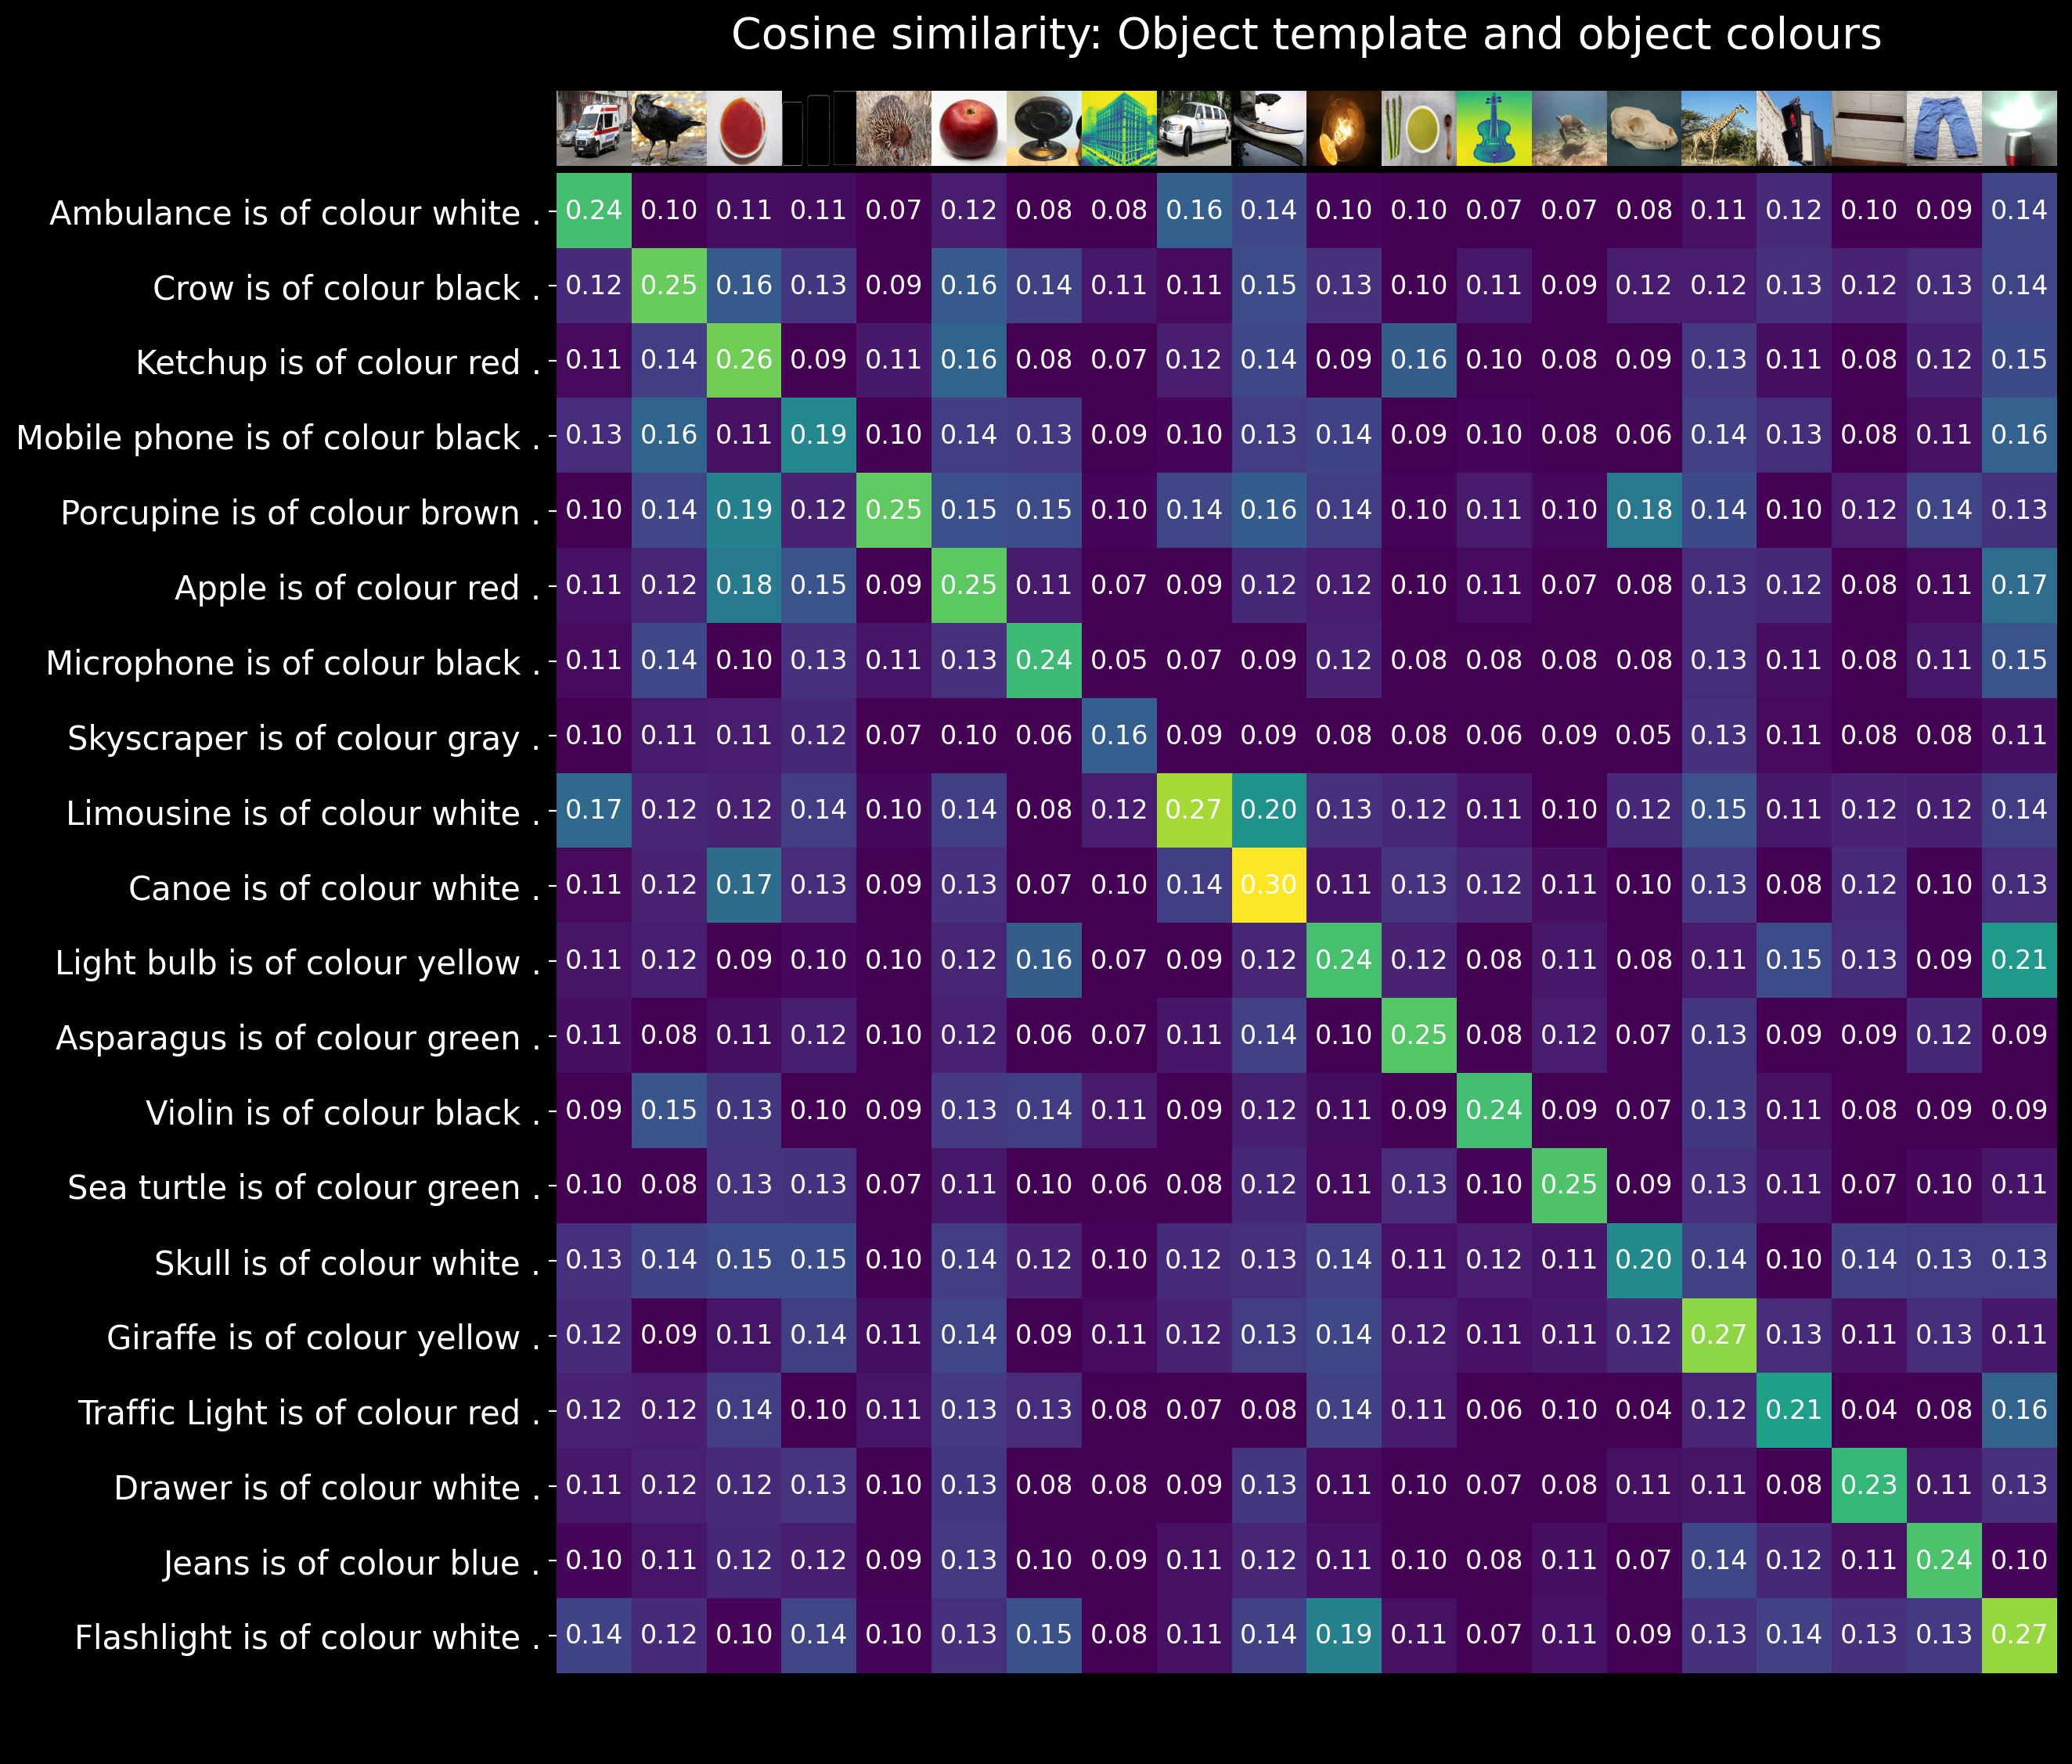

In [184]:
plot_conf_matrix(templates, object_images, color_similarity,
                    "Cosine similarity: Object template and object colours")

### CLIP Obj : Images being converted to grayscale

In [176]:
# https://stackoverflow.com/a/12201744
grayscale_images = [img.convert("LA") for img in object_images]
grayscale_images = [preprocess(img) for img in grayscale_images]


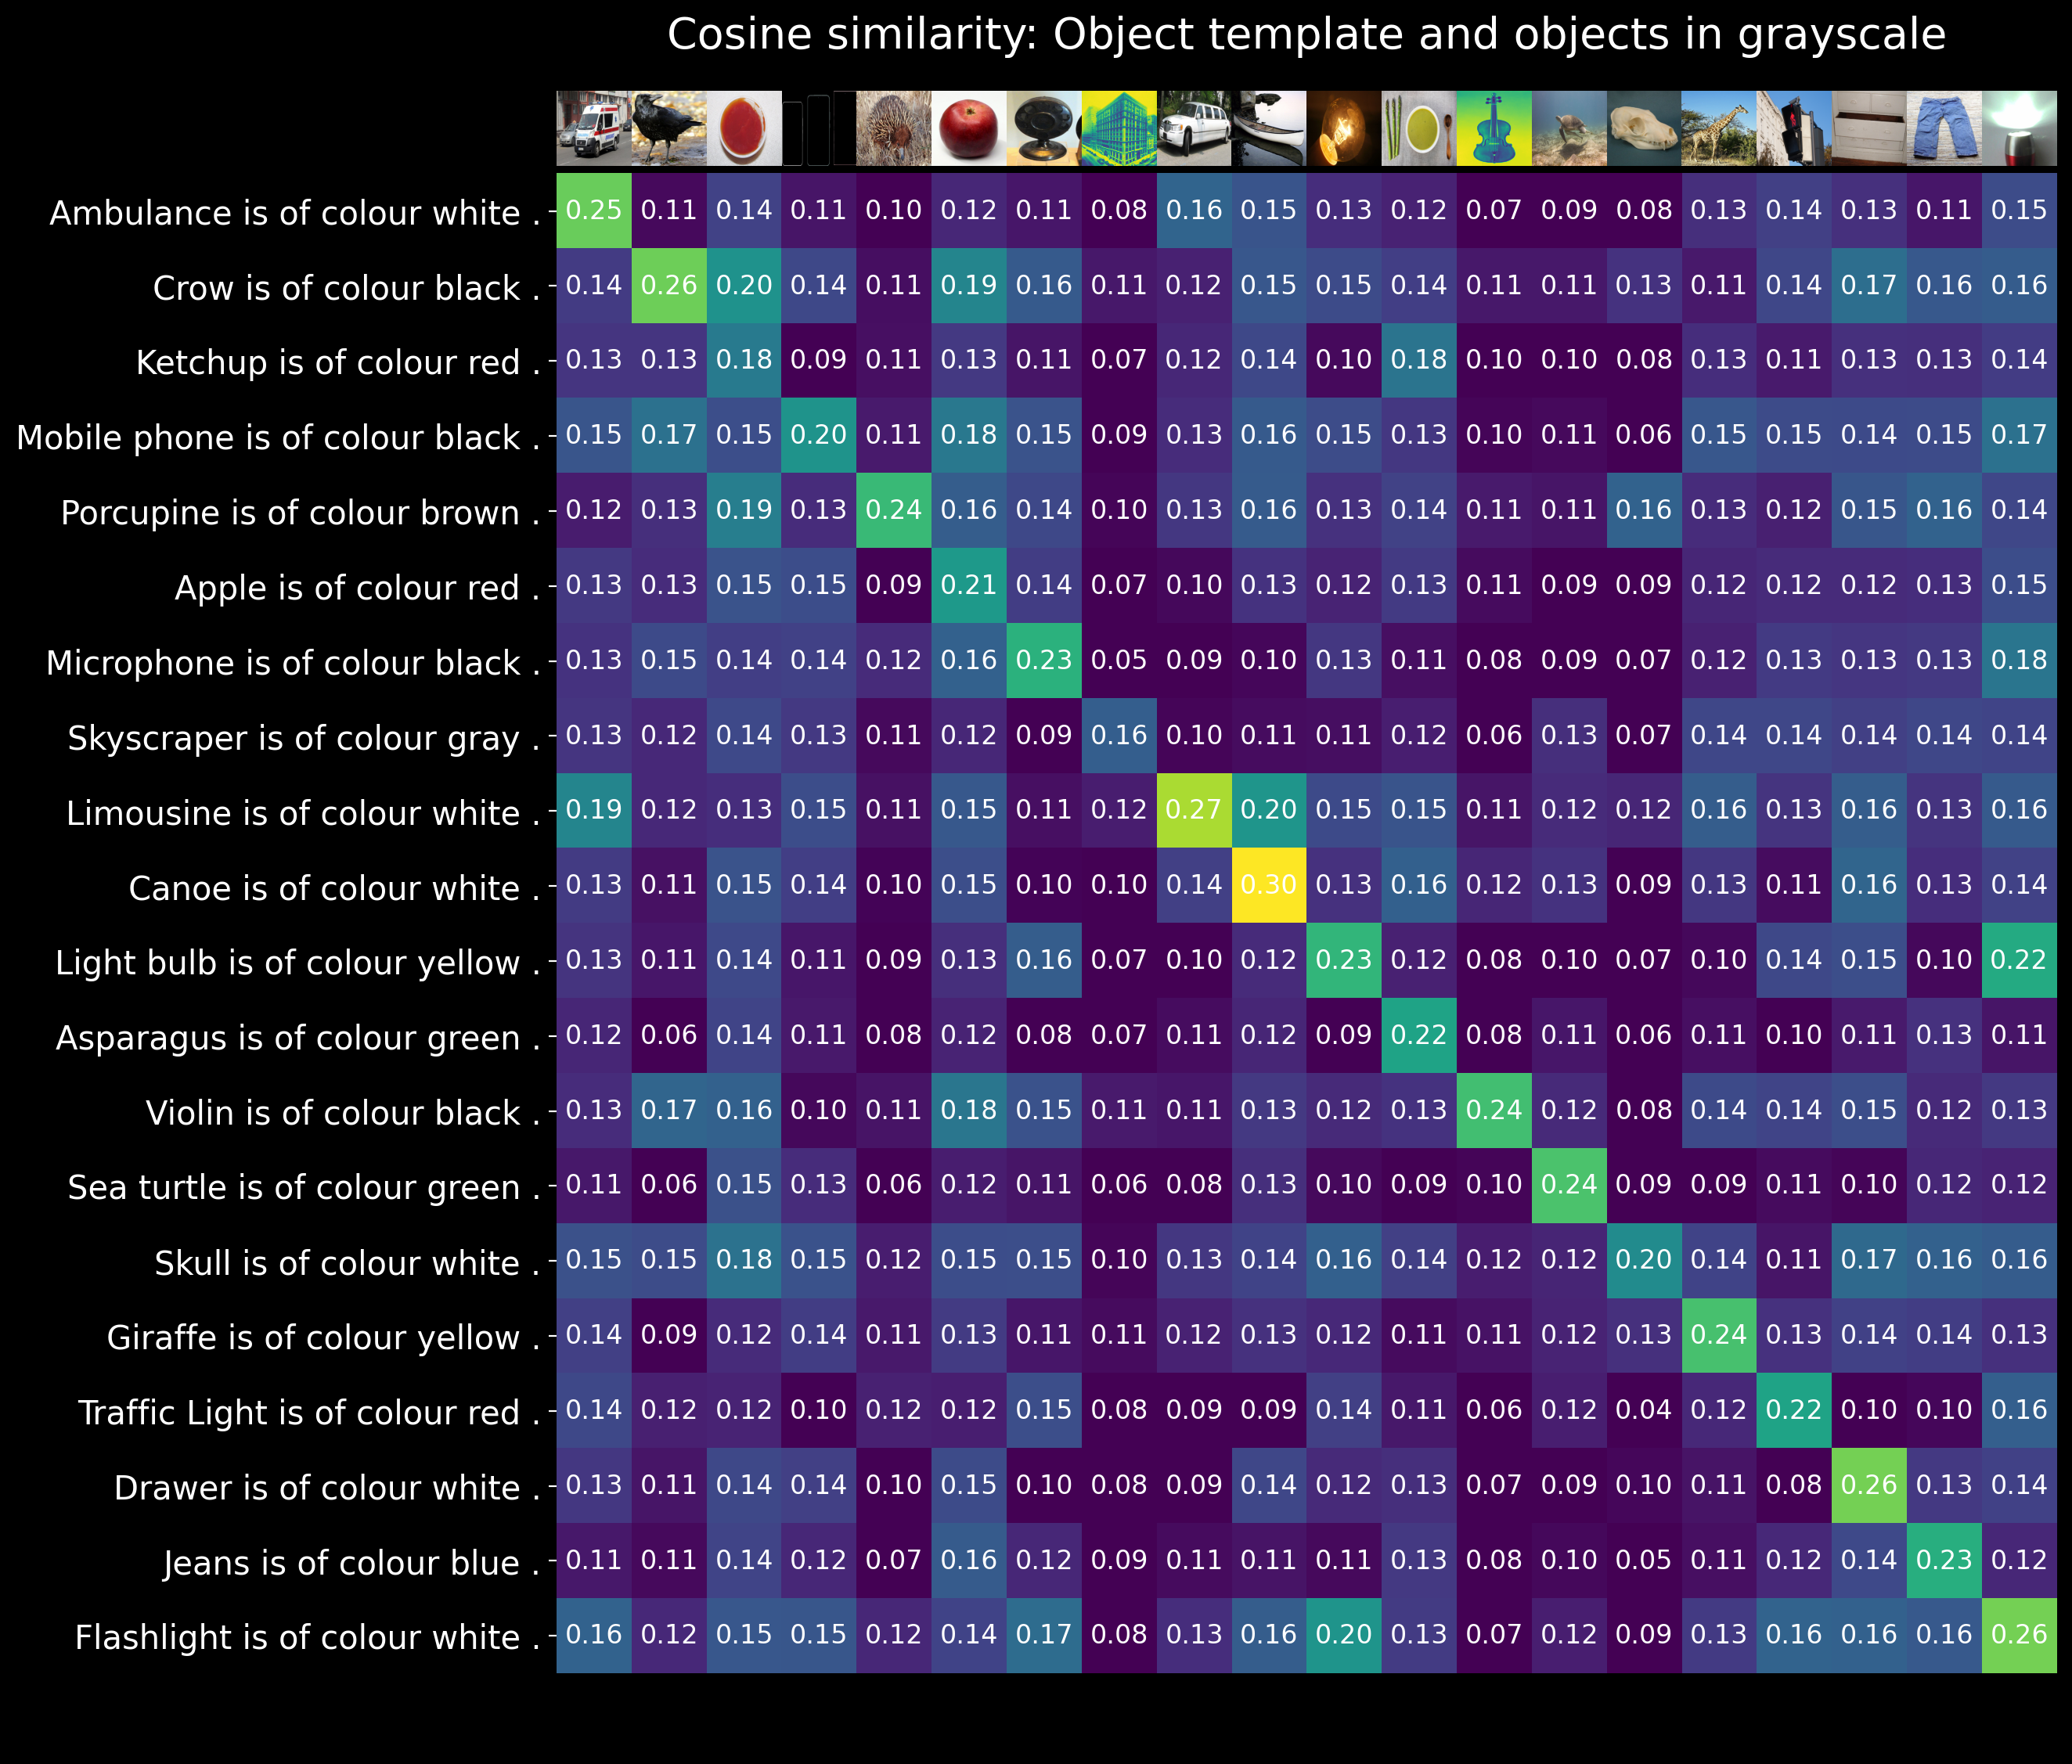

In [185]:
image_inputs, text_inputs = build_inputs(templates, grayscale_images)
image_features, text_features = get_features(image_inputs, text_inputs)
gray_similarity = get_similarity(text_features, image_features)

plot_conf_matrix(templates, object_images, gray_similarity,
                    "Cosine similarity: Object template and objects in grayscale")